<a href="https://colab.research.google.com/github/gustavoalcantara/data-porfolio/blob/main/geospatial_etl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapting geospatial data for BigQuery
- Geospatial data holds great importance as it encompasses precise information about the geometry of phenomena or the exact location of objects on the Earth's surface or subsurface. When conducting geospatial analysis in BigQuery, it is necessary for the data to adhere to a standardized format where the geometry type is specified as either "geography" or "geometry". The provided Colab notebook offers a set of ETL (Extract, Transform, Load) processes that can be employed to convert a .shp file into GeoJSON or WKT formats. Additionally, it demonstrates the practical implementation using the "basedosdados" Python package to conduct a basic geospatial analysis.


Transform to GeoJson

In [ ]:
#Installing the packages
!pip install geopandas -q
!pip install fiona -q
!pip install basedosdados -q

In [2]:
#import the packages
import geopandas as gpd
import basedosdados as bd
import pandas as pd
import numpy as np

In [ ]:
#Upload of all files from .shp
gdf = gpd.read_file('malaria.shp')

In [ ]:
#Convert to a GeoJSON
gdf.to_file(filename ='malaria', driver='GeoJSON')

In [ ]:
#Reading the archive
gdf = gpd.read_file('/content/malaria')

In [ ]:
#The content of geometry
gdf['geometry'].describe()

count                               64
unique                              64
top       POINT (-60.6769333 -2.57989)
freq                                 1
Name: geometry, dtype: object

<Axes: >

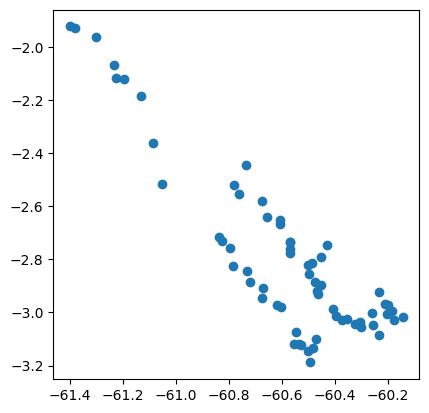

In [ ]:
gdf.plot()

Transform to a WKT

In [ ]:
#With my previously shapefile added, lets convert to a Well Known Text (WKT)
gdf = gpd.read_file('malaria.shp')

In [ ]:
#conversion to a wkt/geometry
gdf['geometry'] = gdf['geometry'].apply(lambda wkt: loads(wkt))
gdf = gdf.set_geometry('geometry')

In [ ]:
gdf['geometry'].describe()

count                               64
unique                              64
top       POINT (-60.6769333 -2.57989)
freq                                 1
Name: geometry, dtype: object

<Axes: >

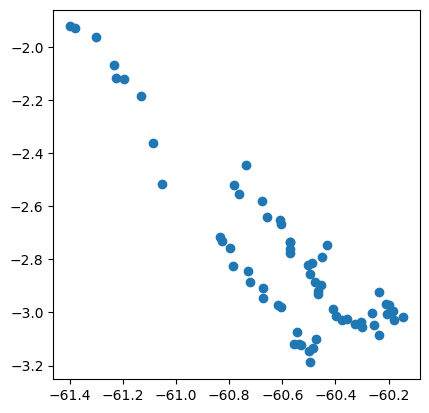

In [ ]:
#Remember: this points doesnt have a EPSG or Datum.
gdf.plot()

Assigning a WKT from a txt/csv file that does not have a prior spatial attribution

In [4]:
#Reading the .txt or .csv
x = pd.read_csv('condicao_entrevistado.txt', sep ='\t')

#Assigning the EPSG to declare the lat/long as a spatial file
crs = {'init': 'epsg:4326'}

#String replace from comma to point of spatial variables
x['x'] = x['x'].str.replace(',', '.')
x['y'] = x['y'].str.replace(',', '.')

#Change to Float64
x['x'] = x['x'].astype(np.float64)
x['y'] = x['y'].astype(np.float64)

#Assigning the geometry variables
from shapely.geometry.polygon import Point
geometry = [Point(xy) for xy
            in zip(x['x'], x['y'])]

#For being a point, it became point, if polygon, assign polygon and so on
geo_df = gpd.GeoDataFrame(x,
                          crs = crs,
                          geometry = geometry)
geo_df['geometry'].head()

0    POINT (-60.67693 -2.57989)
1    POINT (-60.26111 -3.00310)
2    POINT (-60.30543 -3.03741)
3    POINT (-60.35581 -3.02633)
4    POINT (-60.49681 -2.85660)
Name: geometry, dtype: geometry

<Axes: >

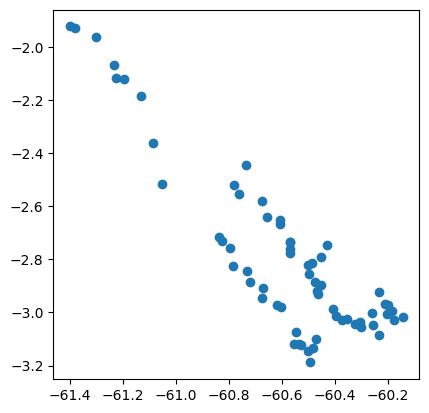

In [9]:
geo_df.plot()

After this treatment, it is possible to upload the spatial variable as geometry to the datalake. I use the .csv format and include the geometry format in the variable’s metadata. For this, I use the basedosdados package in python for filling and validating metadata. In this sense, the generated file follows this metadata standard and you can [check it](https://github.com/basedosdados/mais/blob/master/bases/br_geobr_mapas/municipio/table_config.yaml)


Now, let’s use geospatial data to generate a simple visualization in a .sql query of the distribution of bank branches in the city of Americana - SP in March 2020.

In [15]:
query = '''
SELECT instituicao, nome_agencia, fone, logradouro, cnpj, latitude, longitude,
ST_GEOGPOINT(longitude, latitude) as geometry
FROM basedosdados.br_bcb_agencia.agencia a
INNER JOIN basedosdados.br_bd_diretorios_brasil.cep b
ON a.cep = b.cep
WHERE ano = 2020 AND mes = 3 AND cidade = 'Americana'
'''
df = bd.read_sql(query, billing_project_id='basedosdados-dev')

Downloading: 100%|██████████| 35/35 [00:00<00:00, 207.47rows/s]


In [19]:
#Stop here
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   instituicao   35 non-null     object 
 1   nome_agencia  35 non-null     object 
 2   fone          35 non-null     object 
 3   logradouro    35 non-null     object 
 4   cnpj          35 non-null     object 
 5   latitude      35 non-null     float64
 6   longitude     35 non-null     float64
 7   geometry      35 non-null     object 
dtypes: float64(2), object(6)
memory usage: 2.3+ KB
